In [1]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import pandas as pd
from sklearn import svm
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
from sklearn.model_selection import train_test_split
from sklearn import datasets
from matplotlib.colors import ListedColormap
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit,StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV, LeaveOneOut, cross_val_predict
from sklearn.model_selection import KFold  
from sklearn.linear_model import LogisticRegression  
from sklearn.naive_bayes import GaussianNB  
from sklearn.neighbors import KNeighborsClassifier   
from sklearn import svm  
from sklearn.tree import DecisionTreeClassifier  
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score
import math
import datetime
import multiprocessing as mp
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

import random


# In[25]:


# cores = mp.cpu_count()
# pool = mp.Pool(processes=20)

# min1=min(list(X_standard.shape))
# a1=list(range(10,min1,10))
# a1[-1]=min1
# pcc_top1=pool.map(find_best_pca_lr,a1)  ##（SVM，LR）
# pool.terminate()


# a1=pd.DataFrame()
# for i1 in pcc_top1:
#     a1=pd.concat([a1,i1], axis=0)
# a1.columns=['tr_TP', 'tr_TN', 'tr_FP', 'tr_FN', 'tr_Sen', 'tr_Spe', 'tr_Acc', 'tr_PPV', 'tr_NPV', 'tr_MCC', 'tr_AUC','TP',
#        'TN', 'FP', 'FN', 'Sen', 'Spe', 'Acc', 'PPV', 'NPV', 'MCC', 'AUC','PCA']   

# a1=a1.sort_values(['Acc','tr_Acc','PCA'], ascending=[False,False,True])

In [2]:
def read_single_csv(input_path,i):

    df_chunk=pd.read_csv(input_path,
                         chunksize=10000,
#                          sep='\t'
                        sep=i
                        )
    res_chunk=[]
    for chunk in df_chunk:
        res_chunk.append(chunk)
    res_df=pd.concat(res_chunk)
    return res_df

In [3]:
def get_measures_gridloo(label, score):
    label = np.array(label)
    score = np.array(score)
    
    N  = len(label)
    TP = sum((label == 1) & (score == 1))
    TN = sum((label == 0) & (score == 0))
    FP = sum((label == 0) & (score == 1))
    FN = sum((label == 1) & (score == 0))

    # init all measures to nan
    measures = {measure: float("nan") for measure in ("Sen", "Spe", "Acc", "PPV", "NPV", "MCC","AUC")}
    
    measures["TP"] = TP
    measures["TN"] = TN
    measures["FP"] = FP
    measures["FN"] = FN
    
    S = (TP + FN) / N
    P = (TP + FP) / N

    if (TP + FN) > 0: #recall
        measures["Sen"] = round(TP/(TP+FN), 4)

    if (TN + FP) > 0:
        measures["Spe"] = round(TN/(TN+FP), 4)

    if (TP + FP + FN + TN) > 0:
        measures["Acc"] = round((TP+TN)/(TP+FP+FN+TN), 4)

    if (TP + FP) > 0: #precision
        measures["PPV"] = round(TP/(TP+FP), 4)

    if (TN + FN) > 0:
        measures["NPV"] = round(TN/(TN+FN), 4)

    if (S*P*(1-S)*(1-P)) > 0:
        measures["MCC"] = round((TP/N - S*P)/(math.sqrt(S*P*(1-S)*(1-P))), 4)
    
    
    measures["AUC"]= roc_auc_score(label, score)
    return pd.DataFrame([measures],
                        columns=["TP", "TN", "FP",
                                 "FN", "Sen", "Spe", "Acc", "PPV", "NPV", "MCC","AUC"])

In [4]:
##SVM
def find_best_pca(i):
    n_components=i
    estimator = PCA(n_components=n_components,random_state=10)
    pca_X_train = estimator.fit_transform(X_standard)
    pca_X_test = estimator.transform(X_standard_test)
    
    scoring = {'AUC': 'roc_auc'}
    cost = [-5, -3, -1, 1, 3, 5, 7, 9, 11, 13, 15]
    gam = [3, 1, -1, -3, -5, -7, -9, -11, -13, -15]
    parameters =[{'kernel': ['rbf'], 'C': [2**x for x in cost],'gamma':[2**x for x in gam]}]
    
    cvx = StratifiedKFold(n_splits=5, shuffle=True, random_state=10) 
    grid_search=GridSearchCV(estimator=SVC(random_state=10),param_grid=parameters,cv=cvx,scoring='accuracy')
    grid_search.fit(pca_X_train, train_y)
    
    train_pre_y = cross_val_predict(grid_search.best_estimator_, pca_X_train,train_y, cv=cvx)
    train_res1=get_measures_gridloo(train_y,train_pre_y)
#     train_res1['PCA']=n_components
    test_pre_y = grid_search.predict(pca_X_test)
    test_res1=get_measures_gridloo(test_y,test_pre_y)
    test_res1['PCA']=n_components
    
    res=pd.concat([train_res1,test_res1], axis=1)
    return res

In [5]:
def find_best_pca_lr(i):
    n_components=i
    estimator = PCA(n_components=n_components,random_state=10)
    pca_X_train = estimator.fit_transform(X_standard)
    pca_X_test = estimator.transform(X_standard_test)
    
    cvx = StratifiedKFold(n_splits=5, shuffle=True, random_state=10) 

    param_grid = {'penalty':['l2'],
              "C":[0.00001,0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000],  
              "solver":["newton-cg", "lbfgs","liblinear"],
#             "C":list(np.arange(0,0.1,0.005)),   
#               "solver":["newton-cg", "lbfgs","liblinear"]
            }
    LR_grid = LogisticRegression()
    grid_search = GridSearchCV(LR_grid, param_grid=param_grid, cv=cvx ,scoring='accuracy',n_jobs=9)
    grid_search.fit(pca_X_train, train_y)


    train_pre_y = cross_val_predict(grid_search.best_estimator_, pca_X_train,train_y, cv=cvx)
    train_res1=get_measures_gridloo(train_y,train_pre_y)
#     train_res1['PCA']=n_components
   

    test_pre_y = grid_search.predict(pca_X_test)
    test_res1=get_measures_gridloo(test_y,test_pre_y)
    test_res1['PCA']=n_components
    
    res=pd.concat([train_res1,test_res1], axis=1)
    return res

In [13]:
cancer='HNSC'
# path='D:\\lymph_meta_xmiseq\\tcga_data\\'
path='D:\\lymph_meta_xmiseq\\tmp\\men2\\tcga_data\\'

train=pd.read_csv(path+cancer+"\\admat_final.csv").iloc[:,2:].T.values
target=pd.read_csv(path+cancer+"\\gctm_label.csv",index_col=0).values.ravel()

In [183]:
train_X,test_X, train_y, test_y = train_test_split(train,
                                                   target,
                                                   test_size = 0.3,
                                                   stratify=target,
                                                   random_state=10
                                                   )

standardScaler = StandardScaler()
standardScaler.fit(train_X)
X_standard = standardScaler.transform(train_X)
X_standard_test = standardScaler.transform(test_X)

n_components=0.95
estimator = PCA(n_components=n_components,random_state=10)
pca_X_train = estimator.fit_transform(X_standard)
pca_X_test = estimator.transform(X_standard_test)
cvx = StratifiedKFold(n_splits=5, shuffle=True, random_state=10) 

In [185]:
#svm
scoring = {'AUC': 'roc_auc'}
cost = [-5, -3, -1, 1, 3, 5, 7, 9, 11, 13, 15]
gam = [3, 1, -1, -3, -5, -7, -9, -11, -13, -15]
parameters =[{'kernel': ['rbf'], 'C': [2**x for x in cost],'gamma':[2**x for x in gam]}]
cvx = StratifiedKFold(n_splits=5, shuffle=True, random_state=10) 

svc_grid_search=GridSearchCV(estimator=SVC(random_state=10),param_grid=parameters,cv=cvx,scoring='accuracy')
svc_grid_search.fit(pca_X_train, train_y)

#LR
param_grid = {'penalty':['l1', 'l2'],
              "C":[0.00001,0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000],
              "solver":["newton-cg", "lbfgs","liblinear","sag","saga"]
#               "algorithm":['auto', 'ball_tree', 'kd_tree', 'brute']
            }
LR_grid = LogisticRegression(max_iter=1000)
LR_grid_search = GridSearchCV(LR_grid, param_grid=param_grid, cv=cvx ,scoring='accuracy',n_jobs=10)
LR_grid_search.fit(pca_X_train, train_y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.45230769        nan 0.52369231 0.54769231
 0.54769231 0.72153846 0.76123077 0.74523077        nan        nan
 0.45230769        nan 0.50030769 0.75292308 0.75292308 0.75292308
 0.79230769 0.75292308        nan        nan 0.45230769        nan
 0.52369231 0.848      0.848      0.82430769 0.864      0.832
        nan        nan 0.68246154        nan 0.75292308 0.888
 0.888      0.87230769 0.88       0.88              nan        nan
 0.92              nan 0.92       0.88061538 0.88061538 0.85661538
 0.86461538 0.86461538        nan        nan 0.944             nan
 0.936      0.84061538 0.84061538 0.86461538 0.86461538 0.87261538
        nan        nan 0.944             nan 0.87261538 0.84861538
 0.84861538 0.86461538 0.86461538 0.87261538        nan        nan
 0.90430769        nan 0.87261538 0.85661538 0.85661538 0.84861

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
             estimator=LogisticRegression(max_iter=1000), n_jobs=10,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000],
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy')

In [186]:
estimators = [
    ('lr', LR_grid_search.best_estimator_),
    ('svc', svc_grid_search.best_estimator_),
]
clf = StackingClassifier(estimators=estimators, final_estimator=LinearSVC(C=5),n_jobs=10)
clf.fit(pca_X_train, train_y)

StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=1, max_iter=1000,
                                                   penalty='l1',
                                                   solver='liblinear')),
                               ('svc',
                                SVC(C=32, gamma=3.0517578125e-05,
                                    random_state=10))],
                   final_estimator=LinearSVC(C=5), n_jobs=10)

In [187]:
estimators = [
    ('lr', LR_grid_search.best_estimator_),
    ('svc', svc_grid_search.best_estimator_),
]

param_grid = {'final_estimator':[LogisticRegression(C=0.00001),LogisticRegression(C=0.0001),LogisticRegression(C=0.001),LogisticRegression(C=0.01),
                                 LogisticRegression(C=0.1),LogisticRegression(C=1),LogisticRegression(C=10),LogisticRegression(C=100),
                                 LogisticRegression(C=1000)]}

Stacking_grid =StackingClassifier(estimators=estimators,)
Stacking_grid_search = GridSearchCV(Stacking_grid, param_grid=param_grid, cv=cvx ,scoring='accuracy',n_jobs=10)
Stacking_grid_search.fit(pca_X_train, train_y)
Stacking_grid_search.best_estimator_

StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=1, max_iter=1000,
                                                   penalty='l1',
                                                   solver='liblinear')),
                               ('svc',
                                SVC(C=32, gamma=3.0517578125e-05,
                                    random_state=10))],
                   final_estimator=LogisticRegression(C=100))

In [188]:
train_pre_y = cross_val_predict(Stacking_grid_search.best_estimator_, pca_X_train,train_y, cv=cvx)
train_res1=get_measures_gridloo(train_y,train_pre_y)
#     train_res1['PCA']=n_components

test_pre_y = Stacking_grid_search.predict(pca_X_test)
test_res1=get_measures_gridloo(test_y,test_pre_y)

In [189]:
print(train_res1)
print(test_res1)

   TP  TN  FP  FN     Sen     Spe     Acc     PPV     NPV     MCC       AUC
0  64  50   7   5  0.9275  0.8772  0.9048  0.9014  0.9091  0.8076  0.902365
   TP  TN  FP  FN  Sen  Spe  Acc  PPV  NPV  MCC  AUC
0  30  24   0   0  1.0  1.0  1.0  1.0  1.0  1.0  1.0


In [ ]:
%%time
################random seed loop#################
train_aucs=[]
test_aucs=[]
train_scores=[]
test_scores=[]
loopn=10
scoring='roc_auc'
np.random.seed(10)
random_states=np.random.choice(range(101), loopn, replace=False)

#print(random_states)
for i in range(loopn):
    train_X,test_X, train_y, test_y = train_test_split(train,
                                                   target,
                                                   test_size = 0.3,
                                                   stratify=target,
                                                   random_state=random_states[i]
                                                   )
    print("train_x.shpae:")
    print(train_X.shape)

    standardScaler = StandardScaler()
    standardScaler.fit(train_X)
    X_standard = standardScaler.transform(train_X)
    X_standard_test = standardScaler.transform(test_X)
    #calculate max n_components
    estimator = PCA(n_components=0.99,random_state=42)
    pca_X_train = estimator.fit_transform(X_standard)

    n_components=range(10,min(pca_X_train.shape),10)
    print(n_components)
    #n_components=[0.99,0.95,0.90,0.85]
    best_pca_train_aucs=[]
    best_pca_test_aucs=[]
    
    best_pca_train_scores=[]
    best_pca_test_scores=[]
    for j in n_components:
        estimator = PCA(n_components=j,random_state=42)
        pca_X_train = estimator.fit_transform(X_standard)
        pca_X_test = estimator.transform(X_standard_test)
        cvx = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
    
        #scoring = {'AUC': 'roc_auc'}
        cost = [-5, -3, -1, 1, 3, 5, 7, 9, 11, 13, 15]
        gam = [3, 1, -1, -3, -5, -7, -9, -11, -13, -15]
        parameters =[{'kernel': ['rbf'], 'C': [2**x for x in cost],'gamma':[2**x for x in gam]}]

        svc_grid_search=GridSearchCV(estimator=SVC(random_state=42),
                                     param_grid=parameters,cv=cvx,scoring=scoring)
        svc_grid_search.fit(pca_X_train, train_y)

        param_grid = {'penalty':['l1', 'l2'],
                      "C":[0.00001,0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000],
                      "solver":["newton-cg", "lbfgs","liblinear","sag","saga"]
    #               "algorithm":['auto', 'ball_tree', 'kd_tree', 'brute']
                    }
        LR_grid = LogisticRegression(max_iter=1000, random_state=42)
        LR_grid_search = GridSearchCV(LR_grid, param_grid=param_grid, cv=cvx ,scoring=scoring,n_jobs=10)
        LR_grid_search.fit(pca_X_train, train_y)

        estimators = [
            ('lr', LR_grid_search.best_estimator_),
            ('svc', svc_grid_search.best_estimator_),
        ]
        clf = StackingClassifier(estimators=estimators, 
                                 final_estimator=LinearSVC(C=5, random_state=42),n_jobs=10)
        clf.fit(pca_X_train, train_y)

        estimators = [
            ('lr', LR_grid_search.best_estimator_),
            ('svc', svc_grid_search.best_estimator_),
        ]

        param_grid = {'final_estimator':[LogisticRegression(C=0.00001),LogisticRegression(C=0.0001),
                                         LogisticRegression(C=0.001),LogisticRegression(C=0.01),
                                         LogisticRegression(C=0.1),LogisticRegression(C=1),
                                         LogisticRegression(C=10),LogisticRegression(C=100),
                                         LogisticRegression(C=1000)]}

        Stacking_grid =StackingClassifier(estimators=estimators,)
        Stacking_grid_search = GridSearchCV(Stacking_grid, param_grid=param_grid, cv=cvx,
                                            scoring=scoring,n_jobs=10)
        Stacking_grid_search.fit(pca_X_train, train_y)
        Stacking_grid_search.best_estimator_

        train_pre_y = cross_val_predict(Stacking_grid_search.best_estimator_, pca_X_train,train_y, cv=cvx)
        train_res1=get_measures_gridloo(train_y,train_pre_y)

        test_pre_y = Stacking_grid_search.predict(pca_X_test)
        test_res1=get_measures_gridloo(test_y,test_pre_y)
        
        best_pca_train_aucs.append(train_res1.loc[:,"AUC"])
        best_pca_test_aucs.append(test_res1.loc[:,"AUC"])
        
        best_pca_train_scores.append(train_res1)
        best_pca_test_scores.append(test_res1)
    
    train_aucs.append(np.max(best_pca_train_aucs))
    test_aucs.append(best_pca_test_aucs[np.argmax(best_pca_train_aucs)].item())
    
    train_scores.append(best_pca_train_scores[np.argmax(best_pca_train_aucs)])
    test_scores.append(best_pca_test_scores[np.argmax(best_pca_train_aucs)])
    
    print("n_components:")
    print(n_components[np.argmax(best_pca_train_aucs)])
    

train_x.shpae:
(126, 2281)
range(10, 115, 10)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.5               nan 0.5        0.86090576
 0.86090576 0.86090576 0.86090576 0.86090576        nan        nan
 0.5               nan 0.5        0.86739927 0.86739927 0.86869797
 0.86869797 0.86869797        nan        nan 0.5               nan
 0.5        0.89200799 0.89200799 0.89052614 0.89070929 0.89200799
        nan        nan 0.84132534        nan 0.83623876 0.89397269
 0.89397269 0.89137529 0.89904262 0.89666167        nan        nan
 0.94381452        nan 0.94390609 0.91668332 0.91668332 0.92036297
 0.92425907 0.92166167        nan        nan 0.92162837        nan
 0.92175325 0.91657509 0.91657509 0.92036297 0.91646687 0.91646687
        nan        nan 0.91141359        nan 0.91646687 0.90881618
 0.90881618 0.90881618 0.91776557 0.91646687        nan        nan
 0.90881618        nan 0.91646687 0.90881618 0.908816

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.5               nan 0.5        0.88243423
 0.88243423 0.88245088 0.88245088 0.88245088        nan        nan
 0.5               nan 0.5        0.90047453 0.90047453 0.90307193
 0.90307193 0.90307193        nan        nan 0.5               nan
 0.5        0.96173826 0.96173826 0.95937396 0.96054779 0.95935731
        nan        nan 0.84132534        nan 0.83623876 0.98056943
 0.98056943 0.97800533 0.98056943 0.97800533        nan        nan
 0.97535798        nan 0.97665668 0.98058608 0.98058608 0.97545788
 0.97675658 0.97802198        nan        nan 0.96113886        nan
 0.97802198 0.97156177 0.97156177 0.96899767 0.97286047 0.97803863
        nan        nan 0.95860806        nan 0.97673993 0.97027972
 0.97027972 0.96380286 0.97286047 0.97803863        nan        nan
 0.95730936        nan 0.97673993 0.97157842 0.971578

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [31]:
# print('mean')
# print(np.mean(train_scores))
# print(np.mean(test_scores))
# print("std")
# print(np.std(train_scores))
# print(np.std(test_scores))
# pd.DataFrame(tmp_train)
# print(tmp_train)
# print(test_scores)
# print(train_scores)
# print(test_scores)
print("train")
print(pd.concat(train_scores).describe())

train
         TP         TN        FP   FN    Sen       Spe       Acc       PPV  \
count   3.0   3.000000  3.000000  3.0  3.000  3.000000  3.000000  3.000000   
mean   67.0  53.333333  3.666667  2.0  0.971  0.935667  0.955033  0.948433   
std     0.0   1.527525  1.527525  0.0  0.000  0.026786  0.012166  0.020612   
min    67.0  52.000000  2.000000  2.0  0.971  0.912300  0.944400  0.930600   
25%    67.0  52.500000  3.000000  2.0  0.971  0.921050  0.948400  0.937150   
50%    67.0  53.000000  4.000000  2.0  0.971  0.929800  0.952400  0.943700   
75%    67.0  54.000000  4.500000  2.0  0.971  0.947350  0.960350  0.957350   
max    67.0  55.000000  5.000000  2.0  0.971  0.964900  0.968300  0.971000   

            NPV       MCC       AUC  
count  3.000000  3.000000  3.000000  
mean   0.963833  0.909467  0.953344  
std    0.000971  0.024200  0.013399  
min    0.963000  0.888400  0.941648  
25%    0.963300  0.896250  0.946034  
50%    0.963600  0.904100  0.950420  
75%    0.964250  0.920000

In [ ]:
print("test")
print(pd.concat(test_scores).describe())

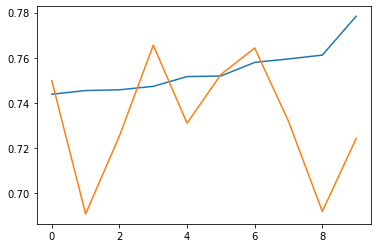

In [9]:
# s_train=sorted(train_scores)
# s_test=sorted(test_scores)

scores=list(range(len(train_scores)))
for i in range(len(train_scores)):
    scores[i]=[train_scores[i],test_scores[i]]

scores.sort(key=lambda x:x[0])

s_train=list(range(len(train_scores)))
s_test=list(range(len(train_scores)))
for i in range(len(train_scores)):
    s_train[i]=scores[i][0]
    s_test[i]=scores[i][1]

import matplotlib.pyplot as plt

plt.plot(s_train)
plt.plot(s_test)
plt.show()

In [367]:
scores

[[0.909643605870021, 0.9210526315789473],
 [0.909643605870021, 0.868421052631579],
 [0.9144654088050315, 0.8802440884820747],
 [0.9318658280922432, 0.9591914569031272],
 [0.9381551362683438, 0.9183829138062548],
 [0.9429769392033542, 0.8802440884820747],
 [0.9461215932914046, 0.8947368421052632],
 [0.9492662473794549, 0.9065598779557589],
 [0.9492662473794549, 0.8421052631578947],
 [0.9763102725366877, 0.9183829138062548]]

In [316]:
random_stat=10
train_X,test_X, train_y, test_y = train_test_split(train,
                                                   target,
                                                   test_size = 0.3,
                                                   stratify=target,
                                                   random_state=random_stat
                                                   )
print("train_x.shpae:")
print(train_X.shape)

standardScaler = StandardScaler()
standardScaler.fit(train_X)
X_standard = standardScaler.transform(train_X)
X_standard_test = standardScaler.transform(test_X)
    #calculate max n_components
estimator = PCA(n_components=0.99,random_state=42)
pca_X_train = estimator.fit_transform(X_standard)

n_components=range(10,min(pca_X_train.shape),10)
print(n_components)
    #n_components=[0.99,0.95,0.90,0.85]
best_pca_train_scores=[]
best_pca_test_scores=[]
train_scores=[]
test_scores=[]
for j in n_components:
    estimator = PCA(n_components=j,random_state=42)
    pca_X_train = estimator.fit_transform(X_standard)
    pca_X_test = estimator.transform(X_standard_test)
    cvx = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
    
        #scoring = {'AUC': 'roc_auc'}
    cost = [-5, -3, -1, 1, 3, 5, 7, 9, 11, 13, 15]
    gam = [3, 1, -1, -3, -5, -7, -9, -11, -13, -15]
    parameters =[{'kernel': ['rbf'], 'C': [2**x for x in cost],'gamma':[2**x for x in gam]}]

    svc_grid_search=GridSearchCV(estimator=SVC(random_state=42),
                                 param_grid=parameters,cv=cvx,scoring=scoring)
    svc_grid_search.fit(pca_X_train, train_y)

    param_grid = {'penalty':['l1', 'l2'],
                  "C":[0.00001,0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000],
                  "solver":["newton-cg", "lbfgs","liblinear","sag","saga"]
    #               "algorithm":['auto', 'ball_tree', 'kd_tree', 'brute']
                  }
    LR_grid = LogisticRegression(max_iter=1000, random_state=42)
    LR_grid_search = GridSearchCV(LR_grid, param_grid=param_grid, cv=cvx ,scoring=scoring,n_jobs=10)
    LR_grid_search.fit(pca_X_train, train_y)

    estimators = [
        ('lr', LR_grid_search.best_estimator_),
        ('svc', svc_grid_search.best_estimator_),
    ]
    clf = StackingClassifier(estimators=estimators, 
                             final_estimator=LinearSVC(C=5, random_state=42),n_jobs=10)
    clf.fit(pca_X_train, train_y)

    estimators = [
        ('lr', LR_grid_search.best_estimator_),
        ('svc', svc_grid_search.best_estimator_),
    ]

    param_grid = {'final_estimator':[LogisticRegression(C=0.00001),LogisticRegression(C=0.0001),
                                    LogisticRegression(C=0.001),LogisticRegression(C=0.01),
                                    LogisticRegression(C=0.1),LogisticRegression(C=1),
                                    LogisticRegression(C=10),LogisticRegression(C=100),
                                    LogisticRegression(C=1000)]}

    Stacking_grid =StackingClassifier(estimators=estimators,)
    Stacking_grid_search = GridSearchCV(Stacking_grid, param_grid=param_grid, cv=cvx,
                                        scoring=scoring,n_jobs=10)
    Stacking_grid_search.fit(pca_X_train, train_y)
    Stacking_grid_search.best_estimator_

    train_pre_y = cross_val_predict(Stacking_grid_search.best_estimator_, pca_X_train,train_y, cv=cvx)
    train_res1=get_measures_gridloo(train_y,train_pre_y)

    test_pre_y = Stacking_grid_search.predict(pca_X_test)
    test_res1=get_measures_gridloo(test_y,test_pre_y)
        
    best_pca_train_scores.append(train_res1.loc[:,"AUC"])
    best_pca_test_scores.append(test_res1.loc[:,"AUC"])
    train_scores.append(train_res1)
    test_scores.append(test_res1)

train_x.shpae:
(89, 38585)
range(10, 85, 10)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.5               nan 0.5        0.99047619
 0.99047619 0.99047619 0.99047619 0.99047619        nan        nan
 0.5               nan 0.5        0.99047619 0.99047619 0.9702381
 0.9702381  0.9702381         nan        nan 0.89047619        nan
 0.89047619 0.99047619 0.99047619 0.95238095 0.95238095 0.95238095
        nan        nan 0.9797619         nan 0.9797619  0.99047619
 0.99047619 0.94880952 0.94880952 0.94880952        nan        nan
 0.95833333        nan 0.95833333 0.99047619 0.99047619 0.9452381
 0.93722222 0.9452381         nan        nan 0.93809524        nan
 0.9452381  0.98690476 0.98690476 0.93007937 0.93722222 0.94079365
        nan        nan 0.93809524        nan 0.94079365 0.98690476
 0.98690476 0.92531746 0.93722222 0.94079365        nan        nan
 0.93809524        nan 0.94079365 0.98333333 0.98333333

In [317]:
print("train_AUC:")
print(np.max(best_pca_train_scores))
print("test_AUC:")
print(best_pca_test_scores[np.argmax(best_pca_train_scores)])
print("n_components:")
print(n_components[np.argmax(best_pca_train_scores)])

print("train_scores:")
print(train_scores[np.argmax(best_pca_train_scores)])
print("test_scores:")
print(test_scores[np.argmax(best_pca_train_scores)])

train_AUC:
0.5
test_AUC:
0    0.5
Name: AUC, dtype: float64
n_components:
10
train_scores:
   TP  TN  FP  FN  Sen  Spe    Acc  PPV    NPV  MCC  AUC
0   0  72   0  17  0.0  1.0  0.809  NaN  0.809  NaN  0.5
test_scores:
   TP  TN  FP  FN  Sen  Spe     Acc  PPV     NPV  MCC  AUC
0   0  31   0   8  0.0  1.0  0.7949  NaN  0.7949  NaN  0.5
